# Install / Import

In [ ]:
!pip install magenta

     |████████████████████████████████| 1.4MB 8.7MB/s 
     |████████████████████████████████| 5.6MB 21.6MB/s 
     |████████████████████████████████| 256kB 48.8MB/s 
     |████████████████████████████████| 3.6MB 54.9MB/s 
     |████████████████████████████████| 358kB 54.5MB/s 
     |████████████████████████████████| 92kB 13.4MB/s 
     |████████████████████████████████| 215kB 63.5MB/s 
     |████████████████████████████████| 1.6MB 52.1MB/s 
     |████████████████████████████████| 204kB 62.8MB/s 
     |████████████████████████████████| 2.3MB 44.5MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 1.5MB 44.6MB/s 
     |████████████████████████████████| 20.2MB 283kB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 655kB 38.6MB/s 
     |████████████████████████████████| 368kB 62.5MB/s 
     |████████████████████████████████| 368kB 60.7MB/s 
     |████████████████████████████████| 194kB 55.0MB

In [ ]:
import sys
from matplotlib  import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from functools        import reduce
from h5py             import File
from glob             import glob
from os               import makedirs
from os.path          import exists, isdir
from pandas           import read_csv
from scipy.io.wavfile import read as readWave

import numpy       as np
import librosa     as lbr

from note_seq.audio_io      import int16_samples_to_float32, crop_samples
from note_seq.midi_io       import midi_file_to_note_sequence
from note_seq.sequences_lib import sequence_to_pianoroll, apply_sustain_control_changes
from magenta.models.onsets_frames_transcription.audio_label_data_utils import find_split_points

/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [ ]:
from google.colab import files
files.upload()

Saving musicnet_metadata.csv to musicnet_metadata.csv


{'musicnet_metadata.csv': b'"id","composer","composition","movement","ensemble","source","transcriber","catalog_name","seconds"\n1727,"Schubert","Piano Quintet in A major","2. Andante","Piano Quintet","European Archive","http://tirolmusic.blogspot.com/","OP114",447\n1728,"Schubert","Piano Quintet in A major","3. Scherzo: Presto","Piano Quintet","European Archive","http://tirolmusic.blogspot.com/","OP114",251\n1729,"Schubert","Piano Quintet in A major","4. Andantino - Allegretto","Piano Quintet","European Archive","http://tirolmusic.blogspot.com/","OP114",444\n1730,"Schubert","Piano Quintet in A major","5. Allegro giusto","Piano Quintet","European Archive","http://tirolmusic.blogspot.com/","OP114",368\n1733,"Schubert","Piano Sonata in A major","2. Andantino","Solo Piano","Museopen","Segundo G. Yogore","D959",546\n1734,"Schubert","Piano Sonata in A major","3. Scherzo. Allegro vivace","Solo Piano","Museopen","Segundo G. Yogore","D959",325\n1735,"Schubert","Piano Sonata in A major","4. Ron

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d imsparsh/musicnet-dataset

100% 21.5G/21.5G [04:39<00:00, 82.7MB/s]
100% 21.5G/21.5G [04:39<00:00, 82.7MB/s]


In [ ]:
!unzip musicnet-dataset.zip

# MusicNet String Data(+ maestro 2014, 2017 Data)

In [ ]:
import glob
import shutil 

wav_path = glob.glob('/content/drive/My Drive/maestro-v1.0.0/2021/*.wav')
midi_path = glob.glob('/content/drive/My Drive/maestro-v1.0.0/musicnet_midis/*.mid')

In [ ]:
import pandas as pd

metadata = pd.read_csv('musicnet_metadata.csv')
string_list = []
string_wav = []
for i, en in enumerate(metadata.ensemble) :
  if 'Violin' in en or 'Cello' in en or 'String' in en or 'Viola' in en:
    string_wav.append(metadata.id[i])
    string_list.append(en)

In [ ]:
midi_path_string = []
for id in string_wav :
  for i in range(len(midi_path)) : 
    if str(id) in midi_path[i] :
      midi_path_string.append(midi_path[i])

In [ ]:
for m in midi_path_string :
  shutil.copy(m, '/content/drive/MyDrive/maestro-v1.0.0/2021')

In [ ]:
wav_list = []
midi_list = []
for w in wav_path :
  wav_list.append(w[-8:])
for m in midi_path_string :
  midi_list.append(m[-8:])

In [ ]:
import random
random.seed(1)
split_list = ['test']*10 + ['validation']*12 + ['train']*100
random.shuffle(split_list)

In [ ]:
musicnet_df = pd.DataFrame({'audio_filename' : wav_list, 'midi_filename' : midi_list})
musicnet_df['split']=split_list
musicnet_df.sort_values('split', inplace=True)
musicnet_df

,audio_filename,midi_filename,split
116,2622.wav,2622.mid,test
34,2156.wav,2156.mid,test
87,2398.wav,2398.mid,test
19,1932.wav,1932.mid,test
83,2382.wav,2382.mid,test
...,...,...,...
10,1824.wav,1824.mid,validation
9,1822.wav,1822.mid,validation
2,1789.wav,1789.mid,validation
105,2521.wav,2521.mid,validation


In [ ]:
dataFolder = '/content/drive/My Drive/maestro-v1.0.0/'
NotExists = lambda song, name: not exists('{} {}.npy'.format(song, name))

In [ ]:
# wav 파일의 melspectrogram, onset, offset, frame, velocity 계산 후 npy 변환 

rate, minSecs, maxSecs, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = 16_000, 5, 20, -40, -40, -0, -0, 40, 40
nFrames = lbr.time_to_frames(maxSecs, rate) + 1

for yearFolder in glob(dataFolder + '/*//'):
  if '2021' in yearFolder :
    if yearFolder.split('//')[0] in ['train', 'test', 'validation']: continue
    print(yearFolder, end='\n\n')
    for i, song in enumerate(glob(yearFolder + '/*.wav')):
      songFile = song.split('/')[-1]
      year = song.split('/')[-2]
      split = musicnet_df['split'][i]
      if not isdir('{}/{}/{}'.format(dataFolder, split, year)): makedirs('{}/{}/{}'.format(dataFolder, split, year))
      print('{} of {}\t{}\t{}'.format(i + 1, len(glob(yearFolder + '/*.wav')), split, song))

      if any(list(map(lambda name: NotExists('{}/{}/{}/{}'.format(dataFolder, split, year, songFile[:-4]), name), 
                ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):

              # wav 파일 numpy 변환 
              nativeRate, y = readWave(song)
              if y.dtype == np.int16: y = int16_samples_to_float32(y)
              elif y.dtype != np.float32: raise AudioIOError('WAV file not 16-bit or 32-bit float PCM, unsupported')
              
              if y.ndim == 2 and y.shape[1] == 2: y = lbr.to_mono(y.T)
              if nativeRate != rate: y = lbr.resample(y, nativeRate, rate)
              
              samples = lbr.util.normalize(y)
              midFile = musicnet_df['midi_filename'][i]

              # midi sequence 변환 후 piano roll 변환 
              sequence = apply_sustain_control_changes(midi_file_to_note_sequence(song[:-3] + 'mid'))
              roll = sequence_to_pianoroll(sequence, 1 / lbr.frames_to_time(1, rate), 21, 108,
                                          onset_length_ms=32, offset_length_ms=32, onset_mode='length_ms')
              splits = [0, sequence.total_time] if split == 'test' else \
                  find_split_points(sequence, samples, rate, minSecs, maxSecs)

              mels, onsets, offsets, actives, volumes = [], [], [], [], []
              for i, (start, end) in enumerate(zip(splits[:-1], splits[1:])):
                  print('\tFragment {} of {}'.format(i + 1, len(splits) - 1), end='\t')
                  if end - start < minSecs:
                      if i not in [0, len(splits) - 2]: print('WARNING: ', end='')
                      print('Skipping short sequence < {} seconds'.format(minSecs))
                      continue
                  
                  #Resampling in crop_wav_data is really slow, and we have already done it once, avoid doing it twice:

                  # melspectogram db로 변환 

                  newMels = lbr.power_to_db(lbr.feature.melspectrogram(samples if start == 0
                          and end == sequence.total_time else crop_samples(samples, rate, start, end - start),
                      rate, n_mels=229, fmin=30, htk=True).astype(np.float32).T).astype(np.float16)
                      
                  # onset, offset, frame, velocity 추출 

                  newOnsets, newOffsets, newActives, newVolumes = map(lambda arr:arr[
                          lbr.time_to_frames(start + lbr.frames_to_time(1, rate) / 2, rate) :
                          lbr.time_to_frames(  end + lbr.frames_to_time(1, rate) / 2, rate) + 1],
                      [roll.onsets, roll.offsets, roll.active, roll.onset_velocities])
                  if split != 'test':
                      if len(newOnsets) == len(newMels) + 1: newOnsets, newOffsets, newActives, newVolumes \
                          = newOnsets[:-1], newOffsets[:-1], newActives[:-1], newVolumes[:-1]
                      elif len(newMels) == len(newOnsets) + 1: newMels = newMels[:-1]
                  elif len(newOnsets) < len(newMels): newMels = newMels[:len(newOnsets)]

                  assert split == 'test' or len(newOnsets) == len(newMels), \
                      'Spectrogram duration is different from piano rolls durations'

                  if not newOnsets.sum():
                      if i not in [0, len(splits) - 2]: print('WARNING: ', end='')
                      print('Skipping empty sequence')
                      continue

                  for note in newActives[0].nonzero()[0]:
                      for i, act in enumerate(newActives):
                          if newOnsets[i][note] or not act[note]: break
                          newActives[i][note] = 0

                  if split != 'test': newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                      lambda arr: np.pad(arr, [(0, nFrames - len(arr)), (0, 0)], 'minimum' if arr is newMels \
                      else 'constant'), [newMels, newOnsets, newOffsets, newActives, newVolumes])
                  assert newMels.shape[:-1] == newOnsets.shape[:-1] == newOffsets.shape[:-1]        \
                          == newActives.shape[:-1] == newVolumes.shape[:-1]                          \
                      and newOnsets.shape == newOffsets.shape == newActives.shape == newVolumes.shape \
                      and newOnsets.shape[1] == 88 and newMels.shape[1] == 229, 'Wrong data shape'
                  mels, onsets, offsets, actives, volumes = map(lambda arr, newArr: arr + [newArr],
                      [mels, onsets, offsets, actives, volumes], [newMels, newOnsets, newOffsets, newActives, newVolumes])
                  print()
              
              for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'],
                                  [mels, onsets, offsets, actives, volumes]):
                  np.save('{}/{}/{}/{} {}'.format(dataFolder, split, year, songFile[:-4], name), arr)
    print()
'All piano pieces have been processed'

# Maestro data(2014, 2015, 2017)

# Dataset: MAESTRO (MIDI and Audio Edited<br>for Synchronous TRacks and Organization)
Downloaded from Google Magenta: https://magenta.tensorflow.org/datasets/maestro#download
## Warning
For some samples last midi note onsets are slightly beyond the duration of the corresponding WAV-audio.


# Not used datasets

## Not used: MAPS (from Fichiers - Aix-Marseille Université)
https://amubox.univ-amu.fr/index.php/s/iNG0xc5Td1Nv4rR

### Issue 1 (small dataset and not as natural)
From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3 "Dataset":

`MAPS ... “performances” are not as natural as the MAESTRO performances captured from live performances.  In addition, synthesized audio makes up a large fraction of the MAPS dataset.`

### Issue 2 (skipped notes)
From https://arxiv.org/pdf/1710.11153.pdf, Page 6, Section 6 "Need for more data, more rigorous evaluation":

`In addition to the small number of the MAPS Disklavier recordings, we have also noticed several cases where the Disklavier appears to skip some notes played at low velocity. For example, at the beginning of the Beethoven Sonata No. 9, 2nd movement, several Ab notes played with MIDI velocities in the mid-20s are clearly missing from the audio...`

### Issue 3 (two chords instead of one)

There is an issue with datasets __*"ENSTDkAm"*__ & __*"ENSTDkCl"*__, subtypes __*"RAND"*__ & __*"UCHO"*__.  They are assumed to have only one chord per one WAV-file.  But sometimes the chord is split into two onset times in corresponding MIDI and TXT-files, and those two onset times fall into two consecutive time-frames of cqt-transform (or mel-transform).

## Not used: MusicNET (from University of Washington Computer Science & Engineering)
https://homes.cs.washington.edu/~thickstn/musicnet.html

From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3 "Dataset":

`As discussed in Hawthorne et al. (2018), the alignment between audio and score is not fully accurate.  One advantage of MusicNet is that it contains instruments other than piano` ... `and a wider variety of recording environments.`

# Train/Test Split

From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3.2 "Dataset Splitting":

1. `No composition should appear in more than one split.`


2. `... proportions should be true globally and also within each composer.  Maintaining these proportions is not always possible because some composers have too few compositions in the dataset.`


3. `The validation and test splits should contain a variety of compositions.  Extremely popular compositions performed by many performers should be placed in the training split.`


4. `... we recommend using the splits which we have provided.`

In [ ]:
dataFolder = '/content/drive/My Drive/maestro-v1.0.0/'

NotExists = lambda song, name: not exists('{} {}.npy'.format(song, name))

df = read_csv(dataFolder + 'maestro-v1.0.0.csv', verbose=True)
df

Tokenization took: 226.54 ms
Type conversion took: 3.01 ms
Parser memory cleanup took: 0.01 ms


,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
3,Alexander Scriabin,"3 Etudes, Op. 65",test,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508
4,Alexander Scriabin,"5 Preludes, Op.15",train,2009,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,400.557826
...,...,...,...,...,...,...,...
1179,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",train,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,245.315516
1180,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",train,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,241.470442
1181,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",train,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,114.696243
1182,Wolfgang Amadeus Mozart,"Sonata in F Major, K533",train,2004,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,1139.198478


# Mel-transform parameters
Don't know why not use Constant-Q transform, but from https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 3 "Model Configuration":

`We use librosa` ... `to compute the same input data representation of mel-scaled spectrograms with log amplitude of the input raw audio with 229 logarithmically-spaced frequency bins, a hop length of 512, an FFT window of 2048, and a sample rate of 16kHz.`

From https://arxiv.org/pdf/1810.12247.pdf, Page 5, Section 4 "Piano Transcription":

`switched to HTK frequency spacing (Young et al., 2006) for the mel-frequency spectrogram input.`

Mel-frequency values are strange:

$f_{min} = 30 Hz$, but the first "A" note of 1st octave is *27.5 Hz*

$f_{max} = 11 025 Hz$ (librosa default), and it is much higher than the last "C" note of 8th octave (*4 186 Hz*).  So, mel-spectrogram will contain lots of high harmonics, and maybe, it will help the CNN-model correctly identify notes in the last octaves.

Maybe (don't know) Mel-scaled spectrogram is used instead of Constant-Q transform, because CQT-transform produces equal number of bins for each note, while mel-frequencies are located such that there are more nearby frequencies for higher notes.  So, mel-spectrogram provides more input data for higher octaves, and the CNN-model can transcribe higher notes with better accuracy.  It can help solve the issue with lots of annoying false-positive notes in high octaves.

## Additional non-linear logarithmic scaling
librosa.power_to_db, ref=1 (default) --> mels decibels are approximately in range *[-40 ... +40]*

# MIDI Pre-Processing
From https://arxiv.org/pdf/1710.11153.pdf

Page 2, Section 2 "Dataset and Metrics":

`... we first translate “sustain pedal” control changes into longer note durations.  If a note is active when sustain goes on, that note will be extended until either sustain goes off or the same note is played again.`

Page 3, Section 3, "Model Configuration":

`... all onsets will end up spanning exactly two frames.  Labeling only the frame that contains the exact beginning of the onset does not work as well because of possible mis-alignments of the audio and labels.  We experimented with requiring a minimum amount of time a note had to be present in a frame before it was labeled, but found that the optimum value was to include any presence.`

# Number of time-frames: 625 + 1 (20 seconds at sample rate of 16 kHz)
From https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 3 "Model Configuration":

`... we split the training audio into smaller files.  However, when we do this splitting we do not want to cut the audio during notes because the onset detector would miss an onset while the frame detector would still need to predict the note’s presence.  We found that 20 second splits allowed us to achieve a reasonable batch size during training of at least 8, while also forcing splits in only a small number of places where notes are active.`

In [ ]:
rate, minSecs, maxSecs, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = 16_000, 5, 20, -40, -40, -0, -0, 40, 40
nFrames = lbr.time_to_frames(maxSecs, rate) + 1

for yearFolder in glob(dataFolder + '/*//'):
    if yearFolder.split('//')[0] in ['train', 'test', 'validation']: continue
    print(yearFolder, end='\n\n')
    for i, song in enumerate(glob(yearFolder + '/*.wav')):
        songFile = song.split('/')[-1]
        year = song.split('/')[-2]
        csvRow = df.loc[df['audio_filename'] == '/'.join([year, songFile])]
        assert csvRow['year'].to_list()[0] == int(year), 'CSV year is incorrect'
        split = csvRow['split'].to_list()
        assert len(split) == 1, 'CSV train/test split is incorrect'
        split = split[0]
        if not isdir('{}/{}/{}'.format(dataFolder, split, year)): makedirs('{}/{}/{}'.format(dataFolder, split, year))
        print('{} of {}\t{}\t{}'.format(i + 1, len(glob(yearFolder + '/*.wav')), split, song))

        if any(list(map(lambda name: NotExists('{}/{}/{}/{}'.format(dataFolder, split, year, songFile[:-4]), name),
                        ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):

            nativeRate, y = readWave(song)
            if y.dtype == np.int16: y = int16_samples_to_float32(y)
            elif y.dtype != np.float32: raise AudioIOError('WAV file not 16-bit or 32-bit float PCM, unsupported')
            
            if y.ndim == 2 and y.shape[1] == 2: y = lbr.to_mono(y.T)
            if nativeRate != rate: y = lbr.resample(y, nativeRate, rate)

            
            samples = lbr.util.normalize(y)
            sequence = apply_sustain_control_changes(midi_file_to_note_sequence(song[:-3] + 'midi'))
            roll = sequence_to_pianoroll(sequence, 1 / lbr.frames_to_time(1, rate), 21, 108,
                                         onset_length_ms=32, offset_length_ms=32, onset_mode='length_ms')
            splits = [0, sequence.total_time] if split == 'test' else \
                find_split_points(sequence, samples, rate, minSecs, maxSecs)

            mels, onsets, offsets, actives, volumes = [], [], [], [], []
            for i, (start, end) in enumerate(zip(splits[:-1], splits[1:])):
                print('\tFragment {} of {}'.format(i + 1, len(splits) - 1), end='\t')
                if end - start < minSecs:
                    if i not in [0, len(splits) - 2]: print('WARNING: ', end='')
                    print('Skipping short sequence < {} seconds'.format(minSecs))
                    continue
                
                # Resampling in crop_wav_data is really slow, and we have already done it once, avoid doing it twice:
                newMels = lbr.power_to_db(lbr.feature.melspectrogram(samples if start == 0
                        and end == sequence.total_time else crop_samples(samples, rate, start, end - start),
                    rate, n_mels=229, fmin=30, htk=True).astype(np.float32).T).astype(np.float16)
                newOnsets, newOffsets, newActives, newVolumes = map(lambda arr:arr[
                        lbr.time_to_frames(start + lbr.frames_to_time(1, rate) / 2, rate) :
                        lbr.time_to_frames(  end + lbr.frames_to_time(1, rate) / 2, rate) + 1],
                    [roll.onsets, roll.offsets, roll.active, roll.onset_velocities])
                if split != 'test':
                    if len(newOnsets) == len(newMels) + 1: newOnsets, newOffsets, newActives, newVolumes \
                        = newOnsets[:-1], newOffsets[:-1], newActives[:-1], newVolumes[:-1]
                    elif len(newMels) == len(newOnsets) + 1: newMels = newMels[:-1]
                elif len(newOnsets) < len(newMels): newMels = newMels[:len(newOnsets)]
                assert split == 'test' or len(newOnsets) == len(newMels), \
                    'Spectrogram duration is different from piano rolls durations'

                if not newOnsets.sum():
                    if i not in [0, len(splits) - 2]: print('WARNING: ', end='')
                    print('Skipping empty sequence')
                    continue

                for note in newActives[0].nonzero()[0]:
                    for i, act in enumerate(newActives):
                        if newOnsets[i][note] or not act[note]: break
                        newActives[i][note] = 0

                if split != 'test': newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                    lambda arr: np.pad(arr, [(0, nFrames - len(arr)), (0, 0)], 'minimum' if arr is newMels \
                    else 'constant'), [newMels, newOnsets, newOffsets, newActives, newVolumes])
                assert newMels.shape[:-1] == newOnsets.shape[:-1] == newOffsets.shape[:-1]        \
                        == newActives.shape[:-1] == newVolumes.shape[:-1]                          \
                    and newOnsets.shape == newOffsets.shape == newActives.shape == newVolumes.shape \
                    and newOnsets.shape[1] == 88 and newMels.shape[1] == 229, 'Wrong data shape'
                mels, onsets, offsets, actives, volumes = map(lambda arr, newArr: arr + [newArr],
                    [mels, onsets, offsets, actives, volumes], [newMels, newOnsets, newOffsets, newActives, newVolumes])
                print()
            
            for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'],
                                 [mels, onsets, offsets, actives, volumes]):
                np.save('{}/{}/{}/{} {}'.format(dataFolder, split, year, songFile[:-4], name), arr)
    print()
'All piano pieces have been processed'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
	Fragment 16 of 73	
	Fragment 17 of 73	
	Fragment 18 of 73	
	Fragment 19 of 73	
	Fragment 20 of 73	
	Fragment 21 of 73	
	Fragment 22 of 73	
	Fragment 23 of 73	
	Fragment 24 of 73	
	Fragment 25 of 73	
	Fragment 26 of 73	
	Fragment 27 of 73	
	Fragment 28 of 73	
	Fragment 29 of 73	
	Fragment 30 of 73	
	Fragment 31 of 73	
	Fragment 32 of 73	
	Fragment 33 of 73	
	Fragment 34 of 73	
	Fragment 35 of 73	
	Fragment 36 of 73	
	Fragment 37 of 73	
	Fragment 38 of 73	
	Fragment 39 of 73	
	Fragment 40 of 73	
	Fragment 41 of 73	
	Fragment 42 of 73	
	Fragment 43 of 73	
	Fragment 44 of 73	
	Fragment 45 of 73	
	Fragment 46 of 73	
	Fragment 47 of 73	
	Fragment 48 of 73	
	Fragment 49 of 73	
	Fragment 50 of 73	
	Fragment 51 of 73	
	Fragment 52 of 73	
	Fragment 53 of 73	
	Fragment 54 of 73	
	Fragment 55 of 73	
	Fragment 56 of 73	
	Fragment 57 of 73	
	Fragment 58 of 73	
	Fragment 59 of 73	
	Fragment 60 of 73	
	Fragment 61 of 73	
	Fragment 62 of 73	
	Fragment 63 of 73	
	Fra

'All piano pieces have been processed'

In [ ]:
# 연도별로 npy 통합 

for splitFolder in ['train', 'test', 'validation']:
    print(splitFolder)
    for yearFolder in glob('{}/{}/*//'.format(dataFolder, 'train')):
      yearFolder = int(yearFolder.split('/')[-2])
      print('\t', yearFolder, end='\n\n')

      # 조건 추가 
      if yearFolder == 2021 or yearFolder == 2017 or yearFolder == 2014 :
        mels, onsets, offsets, actives, volumes = [], [], [], [], []
        for i, [newMels, newOnsets, newOffsets, newActives, newVolumes] in enumerate(zip(*(
                glob('{}/{}/{}/*{}.npy'.format(dataFolder, splitFolder, yearFolder, arr))
                for arr in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
            song = newMels.split(' ')[0]
            assert song == newOnsets.split(' ')[0] == newOffsets.split(' ')[0] == newActives.split(' ')[0] \
                == newVolumes.split(' ')[0], 'Inconsistent number of numpy arrays'
            print('{} of {}'.format(i + 1, len(glob('{}/{}/{}/*Actives.npy'.format(
                dataFolder, splitFolder, yearFolder)))), end='\t')
            newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                lambda arr: np.load(arr, allow_pickle=True), [newMels, newOnsets, newOffsets, newActives, newVolumes])
            mels, onsets, offsets, actives, volumes = map(lambda arr, newArr: (arr + newArr.tolist())
                if splitFolder == 'test' else np.vstack([arr, newArr]) if len(arr) else newArr,
                [mels, onsets, offsets, actives, volumes], [newMels, newOnsets, newOffsets, newActives, newVolumes])
            print(song) 
            if splitFolder != 'test':
                mels, volumes = map(lambda arr: arr.astype(np.float16), [mels, volumes])
                onsets, offsets, actives = map(lambda arr: arr.astype(np.int8), [onsets, offsets, actives])
            for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'], [mels, onsets, offsets, actives, volumes]):
                np.save('{}/{}/{} {}'.format(dataFolder, splitFolder, yearFolder, name), arr)
            print('\n', len(actives), 'samples')
            
            melsFlat, volsFlat = map(np.concatenate, [mels, volumes])
            print('Mels decibels           in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(
                melsFlat.min(), melsFlat.mean(), melsFlat.max()))

            print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]\n'.format(
                volsFlat.min(), volsFlat.mean(), volsFlat.max()))
            for arr in map(np.concatenate, [onsets, offsets, actives]): assert ((arr == 0) | (arr == 1)).all(), \
                    'Onsets, offsets and actives must be only zeros and ones'
            assert volsFlat.min() == 0 and 0 < volsFlat.max() <= 1, 'Wrong normalized MIDI volumes range'

    print(splitFolder, 'saved\n')
'All years combined'

train
	 2021

1 of 100	/content/drive/My

 57 samples
Mels decibels           in range [-68 ... -30 ... 36]
Midi normalized volumes in range [0.0 ... 0.0012 ... 0.47]

2 of 100	/content/drive/My

 84 samples
Mels decibels           in range [-68 ... -28 ... 38]
Midi normalized volumes in range [0.0 ... 0.0019 ... 0.47]

3 of 100	/content/drive/My

 108 samples
Mels decibels           in range [-68 ... -27 ... 39]
Midi normalized volumes in range [0.0 ... 0.0018 ... 0.47]

4 of 100	/content/drive/My

 124 samples
Mels decibels           in range [-68 ... -26 ... 39]
Midi normalized volumes in range [0.0 ... 0.0020 ... 0.47]

5 of 100	/content/drive/My

 142 samples
Mels decibels           in range [-68 ... -26 ... 40]
Midi normalized volumes in range [0.0 ... 0.0023 ... 0.47]

6 of 100	/content/drive/My

 167 samples
Mels decibels           in range [-68 ... -25 ... 40]
Midi normalized volumes in range [0.0 ... 0.0025 ... 0.47]

7 of 100	/content/drive/My

 193 samples
Mels decibels    

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



 2 samples
Mels decibels           in range [-46 ... -22 ... 39]
Midi normalized volumes in range [0.0 ... 0.0028 ... 0.47]

3 of 10	/content/drive/My

 3 samples
Mels decibels           in range [-46 ... -21 ... 39]
Midi normalized volumes in range [0.0 ... 0.0030 ... 0.47]

4 of 10	/content/drive/My

 4 samples
Mels decibels           in range [-46 ... -21 ... 41]
Midi normalized volumes in range [0.0 ... 0.0029 ... 0.47]

5 of 10	/content/drive/My

 5 samples
Mels decibels           in range [-46 ... -22 ... 41]
Midi normalized volumes in range [0.0 ... 0.0034 ... 0.47]

6 of 10	/content/drive/My

 6 samples
Mels decibels           in range [-46 ... -22 ... 41]
Midi normalized volumes in range [0.0 ... 0.0031 ... 0.47]

7 of 10	/content/drive/My

 7 samples
Mels decibels           in range [-46 ... -22 ... 41]
Midi normalized volumes in range [0.0 ... 0.0033 ... 0.47]

8 of 10	/content/drive/My

 8 samples
Mels decibels           in range [-46 ... -21 ... 41]
Midi normalized volume

'All years combined'

In [ ]:
# train/val 폴더 npy 파일 통합 

with File(dataFolder + '/Mels_with train.hdf5', 'w') as f: #, rdcc_nbytes=1024**3*4) as f: # 4 GB cache size
    for splitFolder in ['train', 'validation']:
        print(splitFolder)
        mels, onsets, offsets, actives, volumes = [], [], [], [], []
        for i, [newMels, newOnsets, newOffsets, newActives, newVolumes] in enumerate(zip(*(glob('{}/{}/*{}.npy'.format(
                dataFolder, splitFolder, arr)) for arr in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
            # 추가
            if newOnsets.split(' ')[1][-4:] != '2015' :
              song = newOnsets.split(' ')[1]
              assert song == newOffsets.split(' ')[1] == newActives.split(' ')[1] == newVolumes.split(' ')[1], \
                  'Inconsistent number of numpy arrays'
              print('{} of {}'.format(i + 1, len(glob('{}/{}/*Actives.npy'.format(
                  dataFolder, splitFolder)))), end='\t')

              newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                  lambda arr: np.load(arr, allow_pickle=True), [newMels, newOnsets, newOffsets, newActives, newVolumes])
              
              if splitFolder == 'train':
                  # Memory Error, so at first collect data in resisable HDF5-file, then it can be re-saved to NumPy-file
                  if not mels: mels = f.create_dataset('Mels', data=newMels,
                      maxshape=(None, newMels.shape[1], newMels.shape[2])) # chunks=True
                  else:
                      mels.resize((len(mels) + len(newMels), mels.shape[1], mels.shape[2]))
                      mels[-len(newMels):] = newMels
              else: mels = (mels + newMels.tolist()) if splitFolder == 'test' \
                  else np.vstack([mels, newMels]) if len(mels) else newMels

              onsets, offsets, actives, volumes = map(lambda arr, newArr: (arr + newArr.tolist())
                  if splitFolder == 'test' else np.vstack([arr, newArr]) if len(arr) else newArr,
                  [onsets, offsets, actives, volumes], [newOnsets, newOffsets, newActives, newVolumes])

              print(song)

        for name, arr in zip(['Mels_with', 'Onsets_with', 'Offsets_with', 'Actives_with', 'Volumes_with'], [mels, onsets, offsets, actives, volumes]):
            np.save('{}/{} {}'.format(dataFolder, name, splitFolder), arr)
        print('\n', len(actives), 'samples')
        
        melsFlat, volsFlat = map(np.concatenate, [mels, volumes])
        melsMin, melsMean, melsMax = np.min(melsFlat), np.mean(melsFlat), np.max(melsFlat)
        print('Mels decibels           in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsMin, melsMean, melsMax))
        # assert melsMinMin < melsMin < melsMinMax and melsMeanMin < melsMean < melsMeanMax \
        #     and melsMaxMin < melsMax < melsMaxMax, 'Wrong mels decibels range'

        print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]\n'.format(
            volsFlat.min(), volsFlat.mean(), volsFlat.max()))
        for arr in map(np.concatenate, [onsets, offsets, actives]): assert ((arr == 0) | (arr == 1)).all(), \
                'Onsets, offsets and actives must be only zeros and ones'
        assert volsFlat.min() == 0 and 0 < volsFlat.max() <= 1, 'Wrong normalized MIDI volumes range'

'All splits combined'

train
2 of 4	Drive/maestro-v1.0.0//train/2014
3 of 4	Drive/maestro-v1.0.0//train/2017
4 of 4	Drive/maestro-v1.0.0//train/2021

 8524 samples
Mels decibels           in range [-84 ... -29 ... 43]
Midi normalized volumes in range [0.0 ... 0.0032 ... 0.99]

validation
2 of 4	Drive/maestro-v1.0.0//validation/2017
3 of 4	Drive/maestro-v1.0.0//validation/2014
4 of 4	Drive/maestro-v1.0.0//validation/2021

 1038 samples
Mels decibels           in range [-78 ... -29 ... 42]
Midi normalized volumes in range [0.0 ... 0.0035 ... 0.98]



'All splits combined'

# Logariphmic distribution of notes

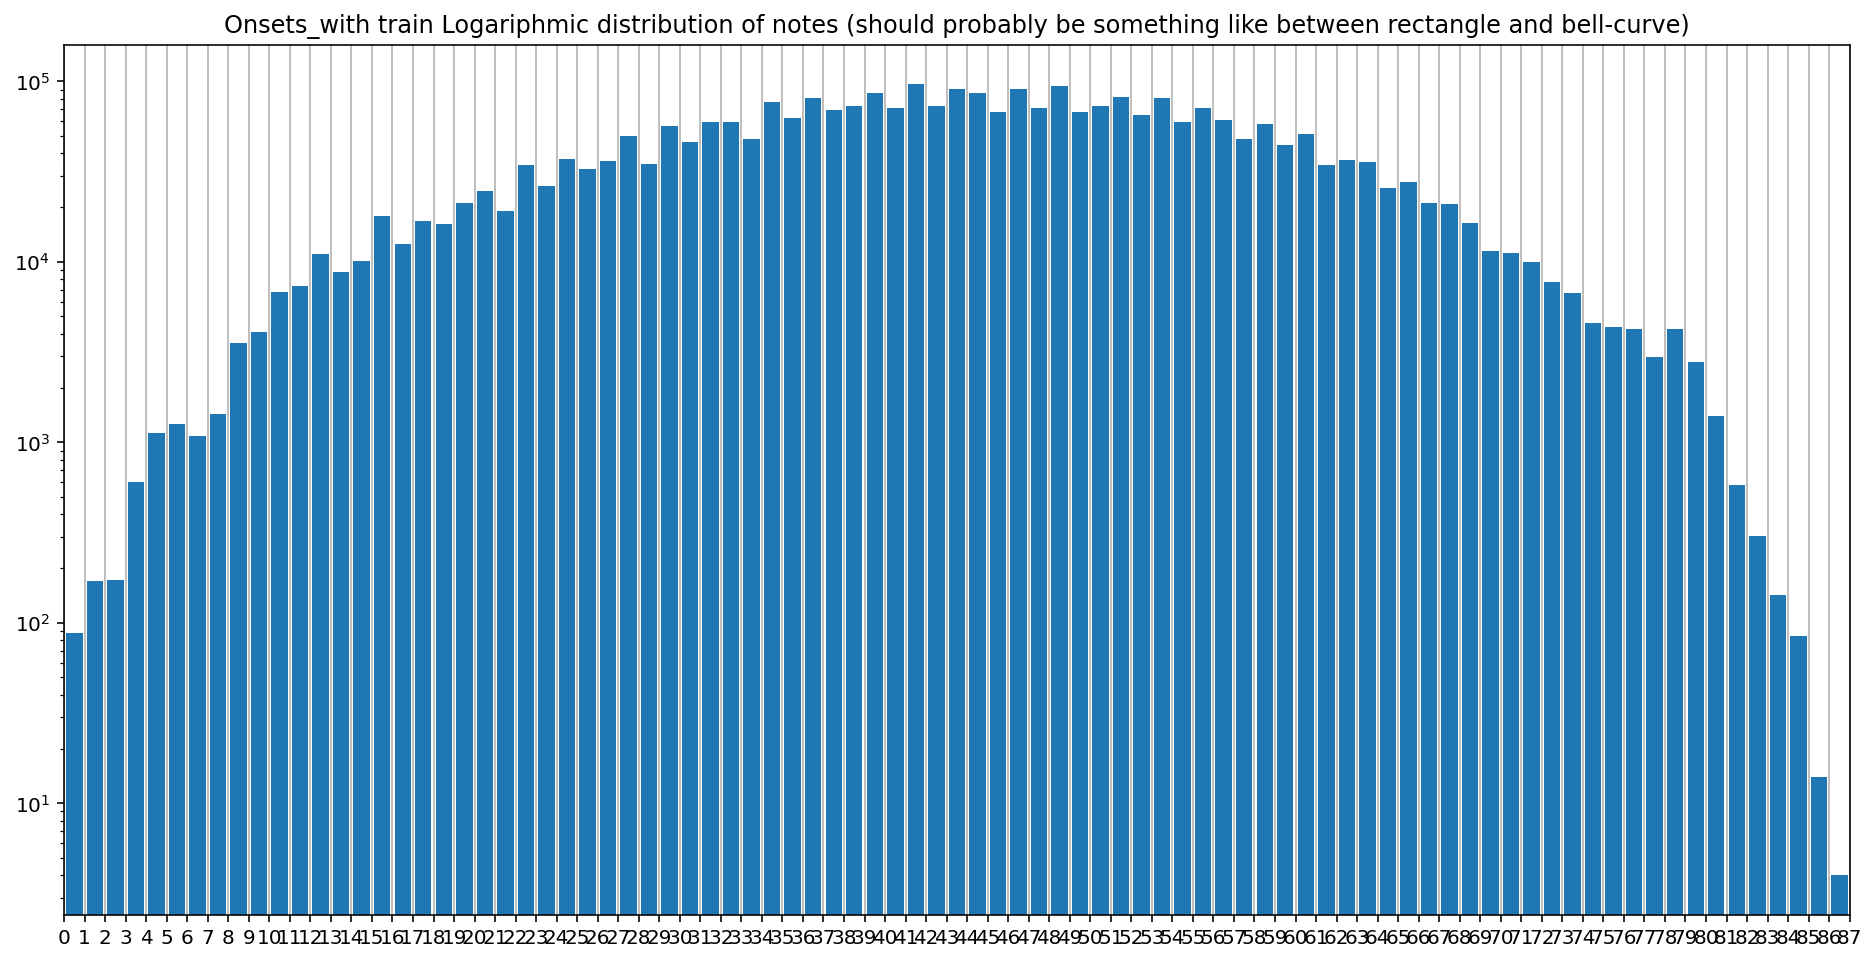

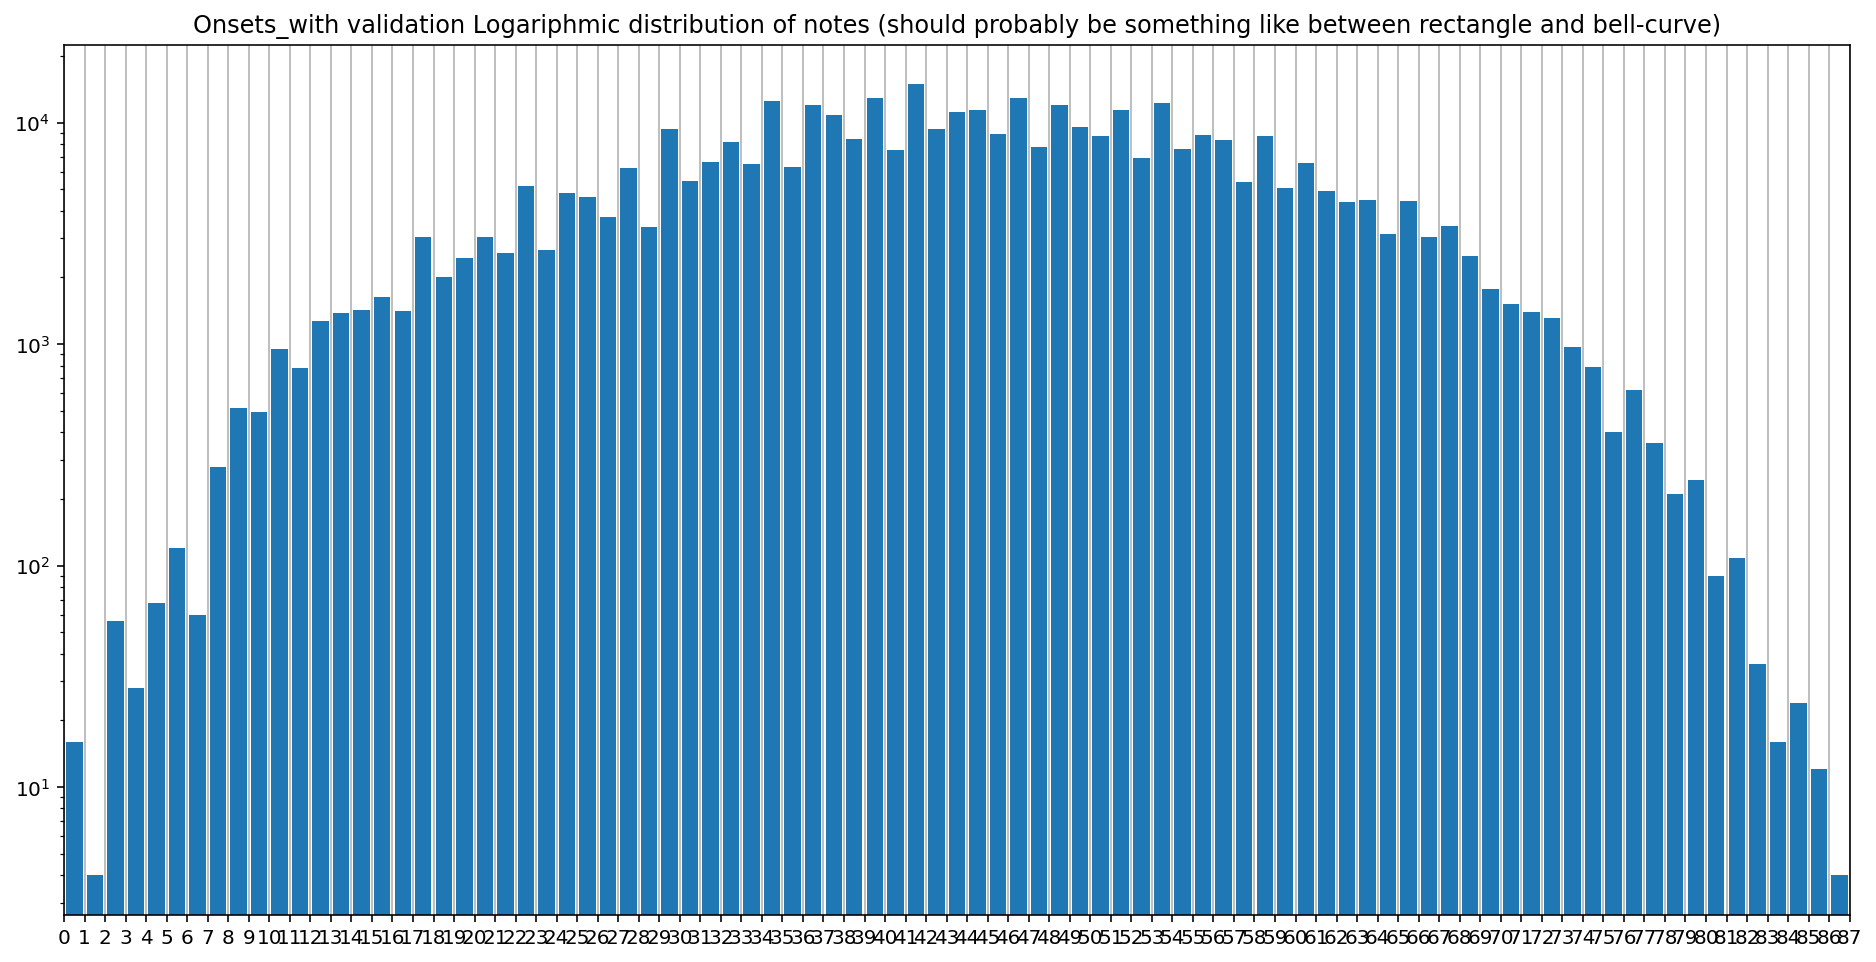

In [ ]:
def PlotNotes(name):
    for split in ['train', 'validation']:
        noteCounts = np.load('{}/{} {}.npy'.format(dataFolder, name, split)).nonzero()[2]
        minNote, maxNote = noteCounts.min(), noteCounts.max()

        plt.figure(figsize=(16, 8))
        plt.hist(noteCounts, maxNote - minNote, rwidth=.8, log=True)
        plt.title('{} {} Logariphmic distribution of notes '
                  '(should probably be something like between rectangle and bell-curve)'.format(name, split))
        plt.xlim(minNote, maxNote)
        plt.xticks(range(minNote, maxNote + 1))
        plt.grid(axis='x')
        plt.savefig('{}'.format(name))

PlotNotes('Onsets_with')

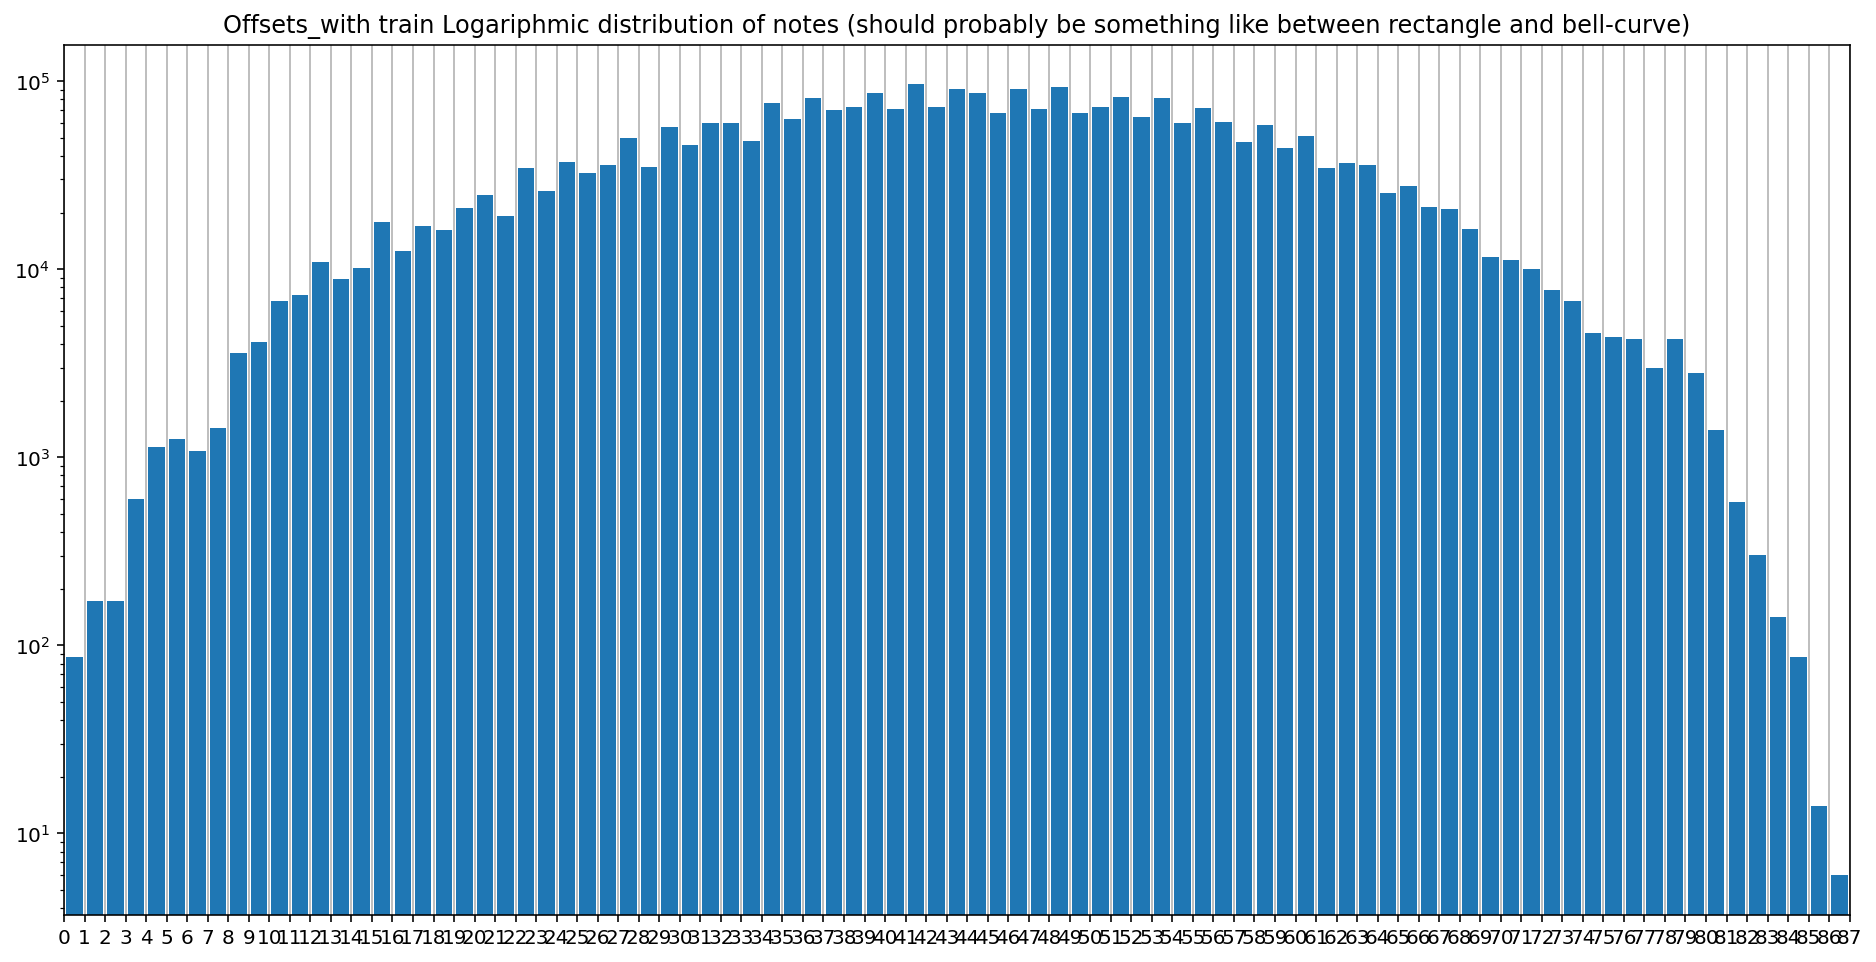

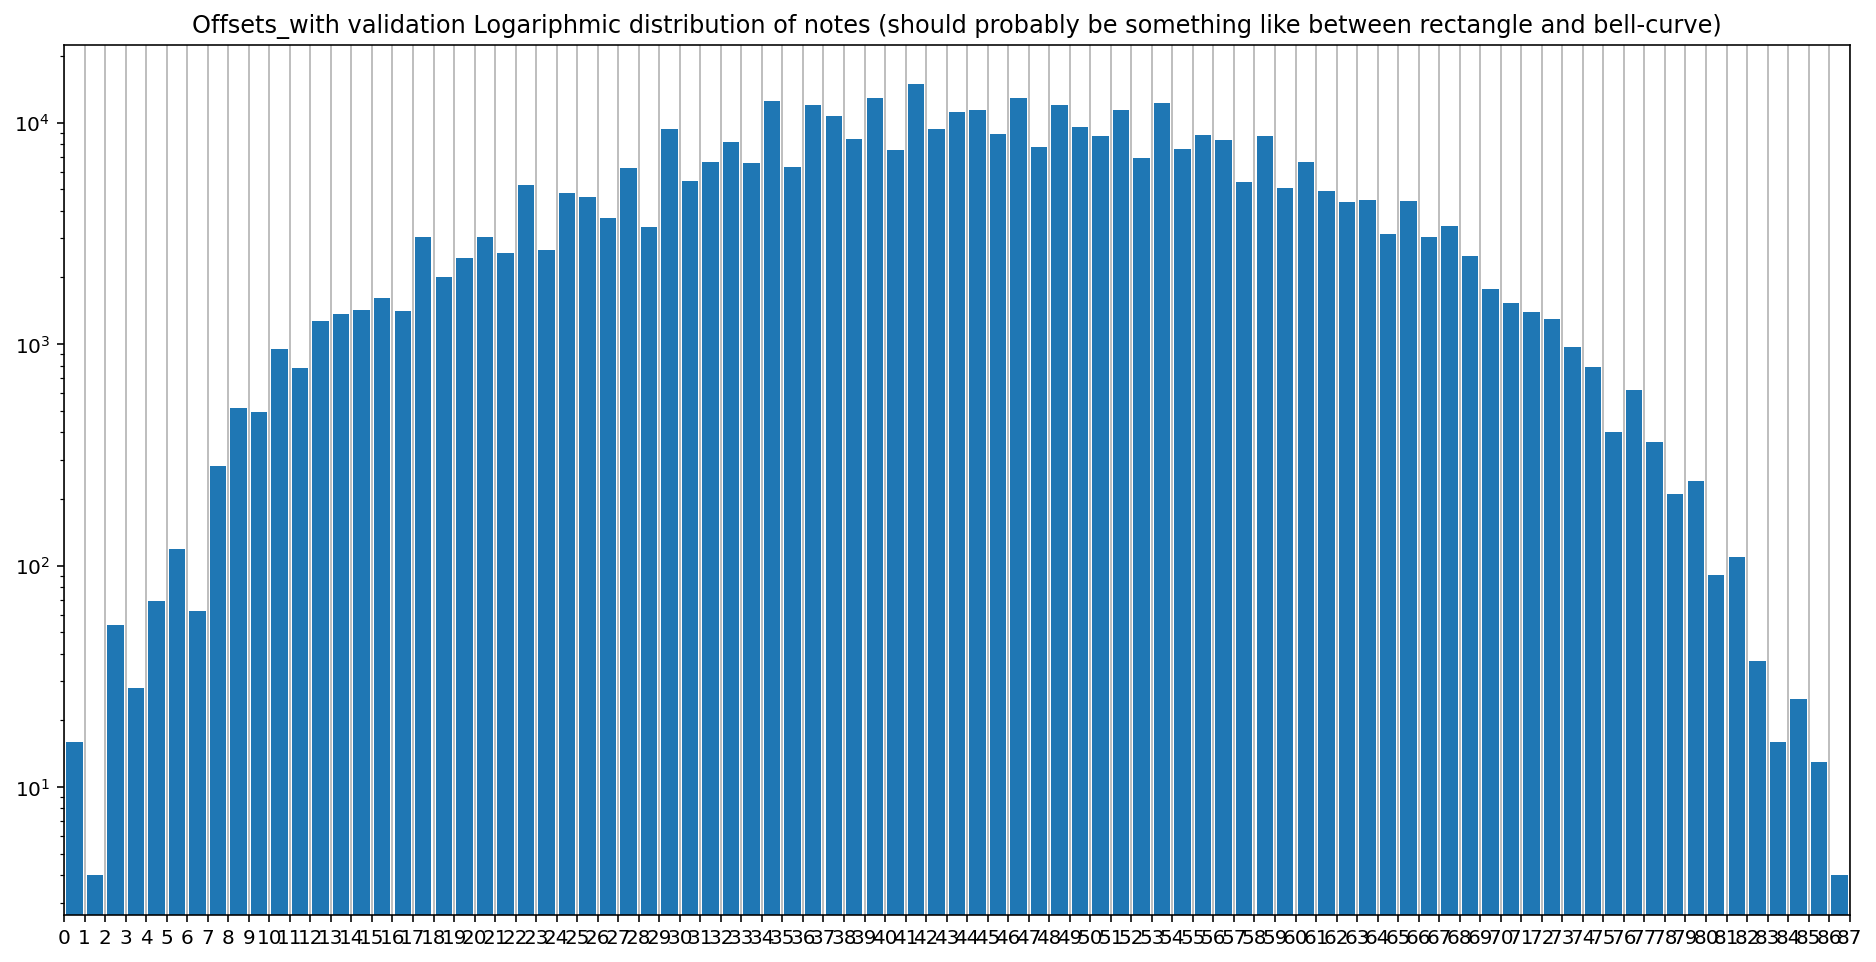

In [ ]:
PlotNotes('Offsets_with') # Should be the same as Onsets

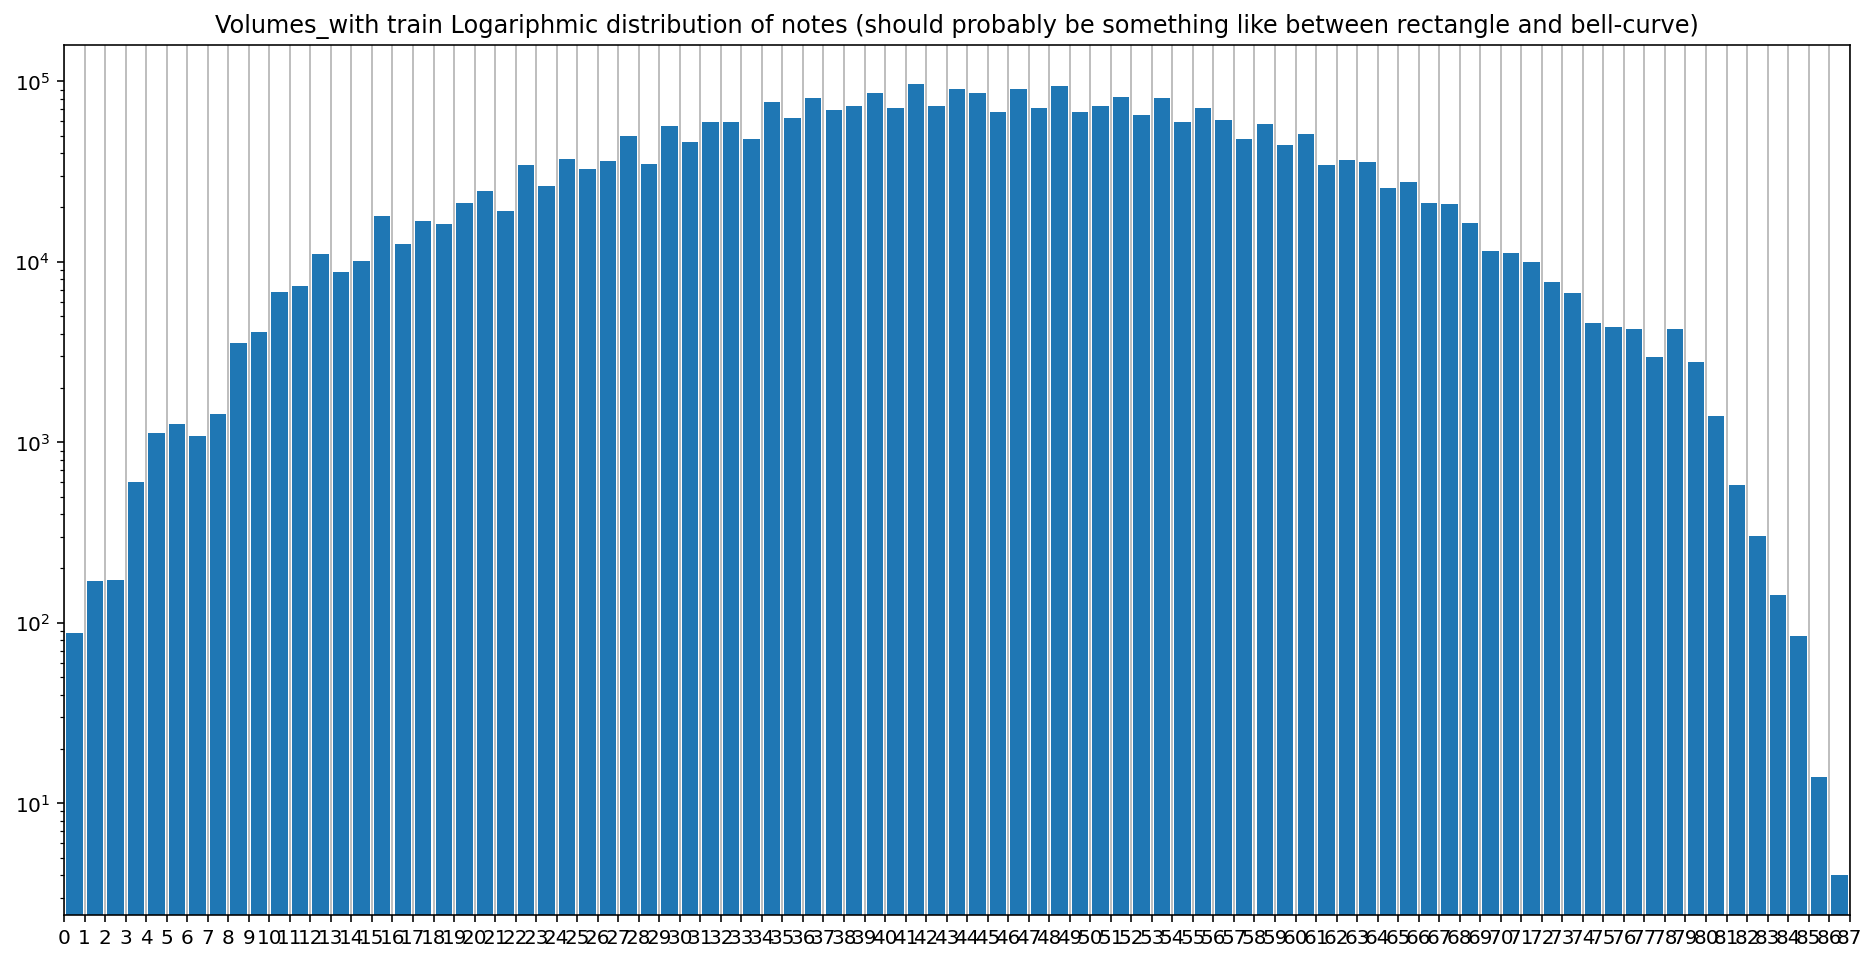

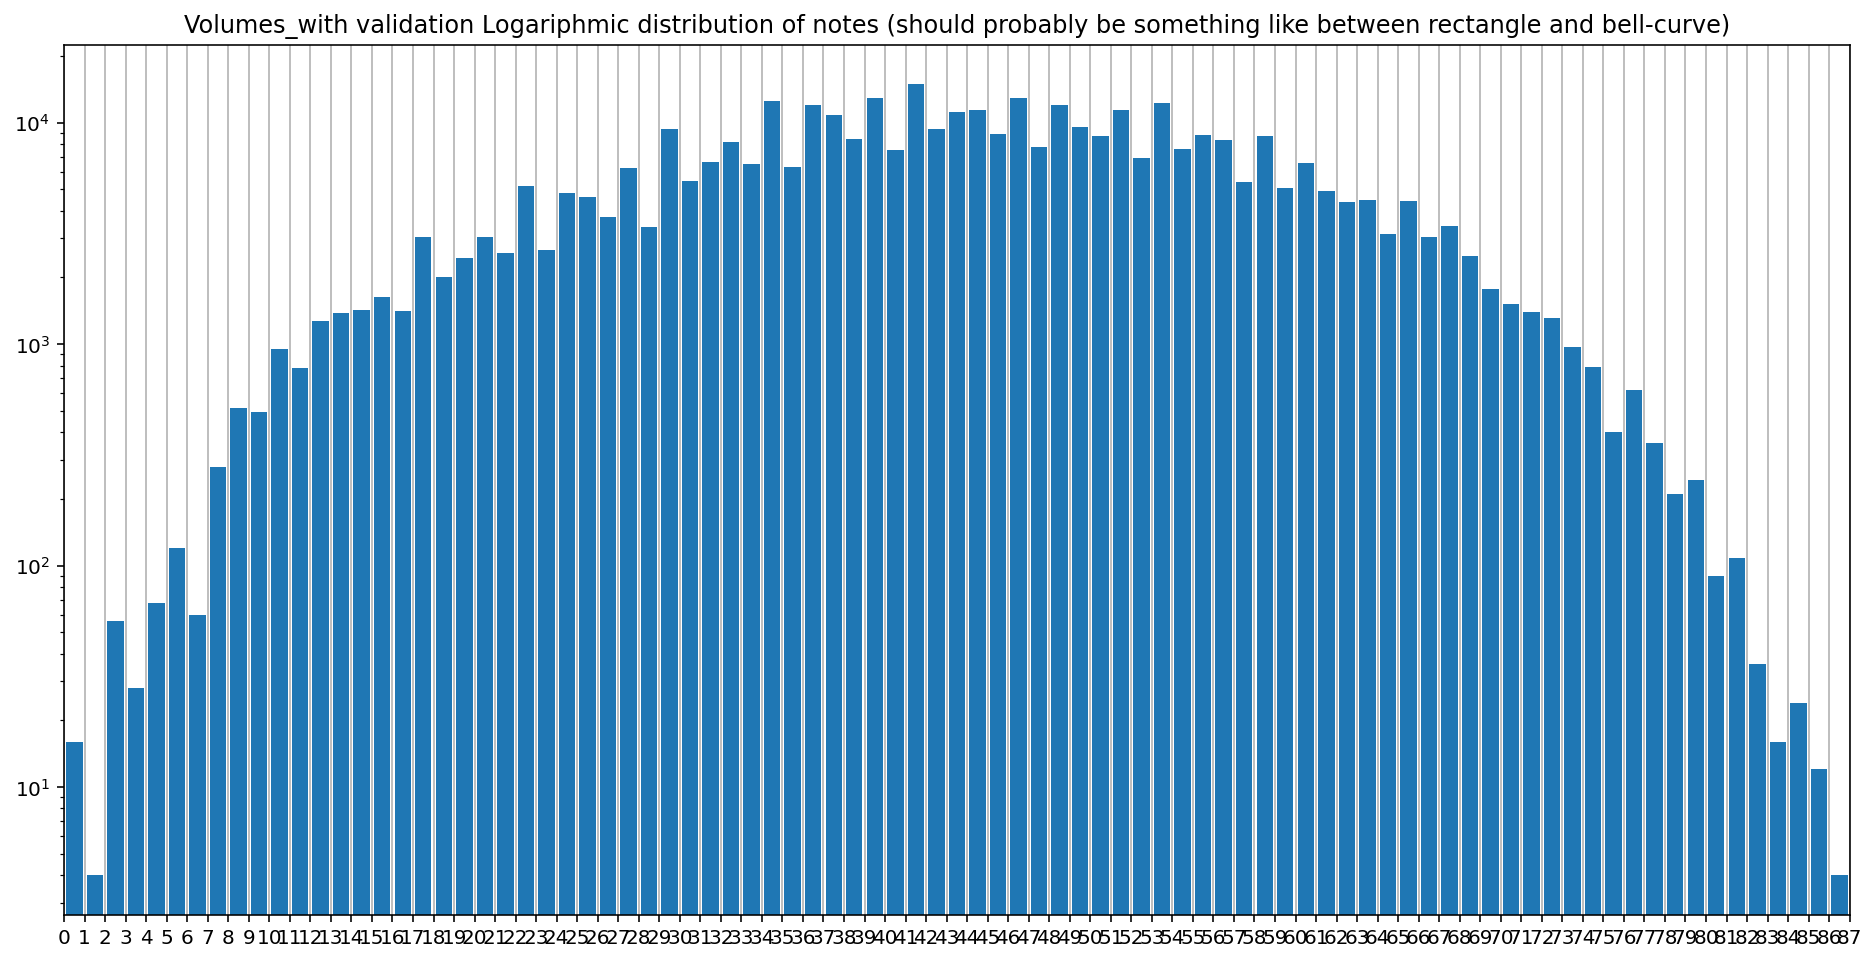

In [ ]:
PlotNotes('Volumes_with') # Should be the same as Onsets and Offsets

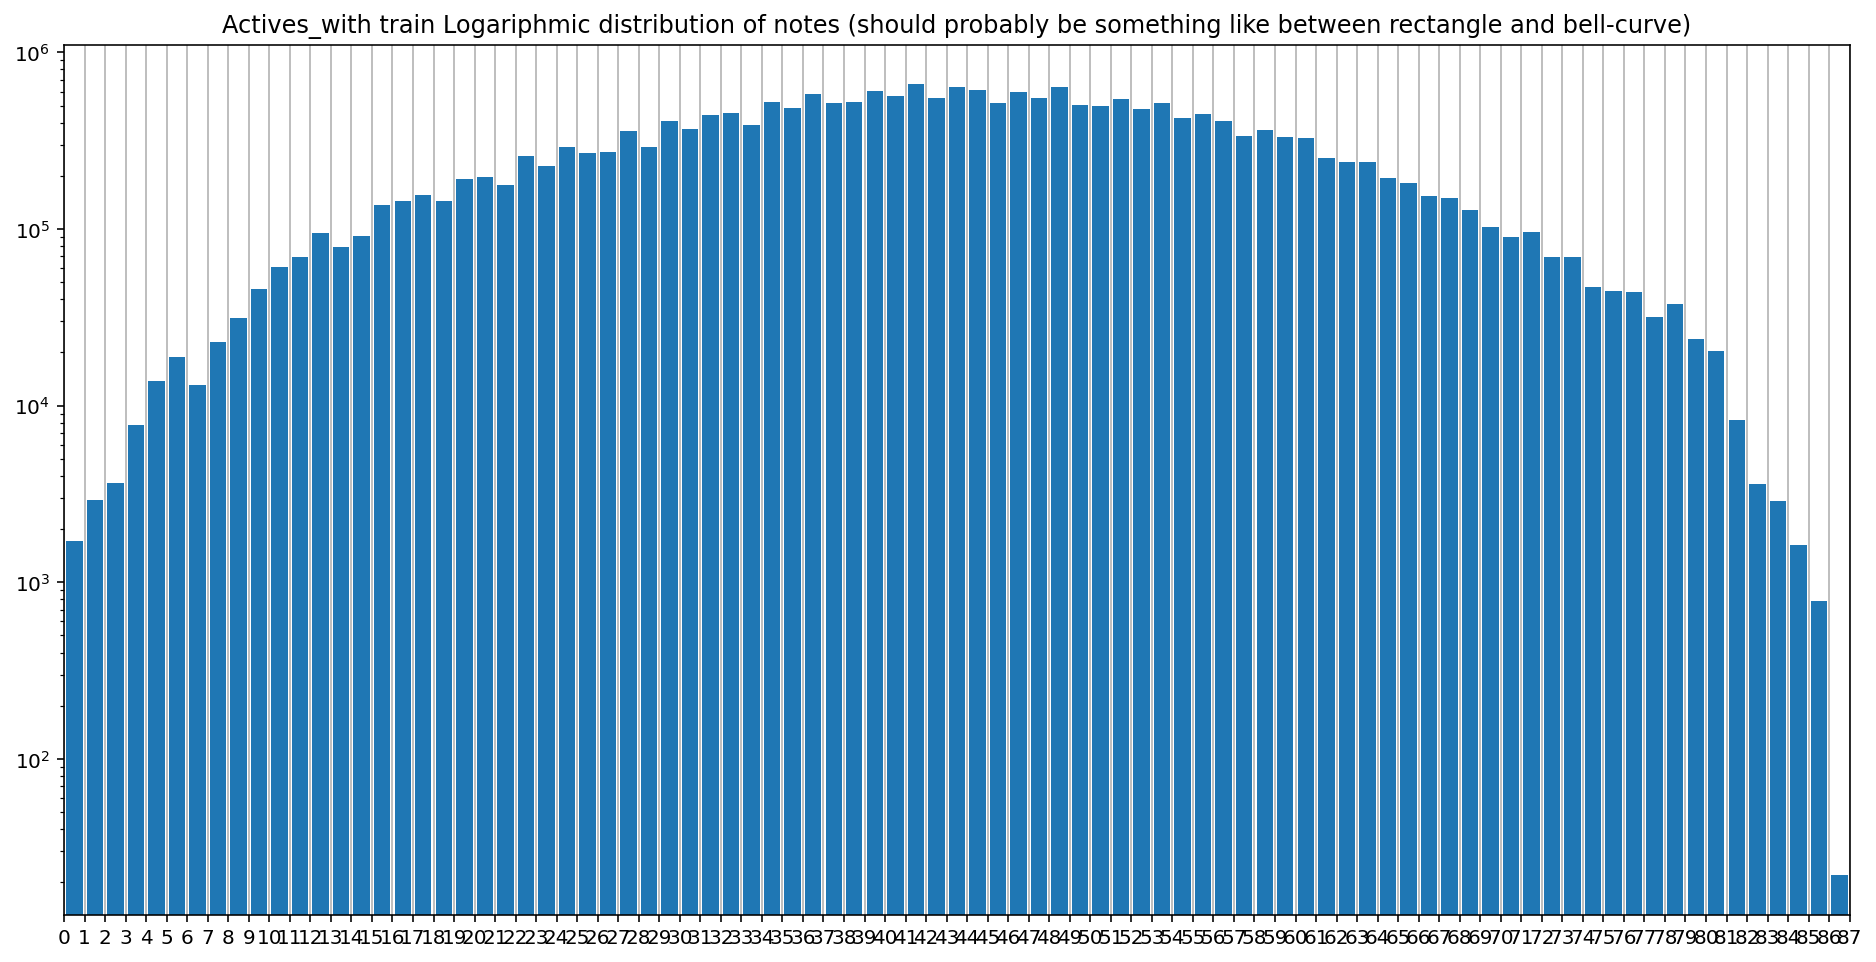

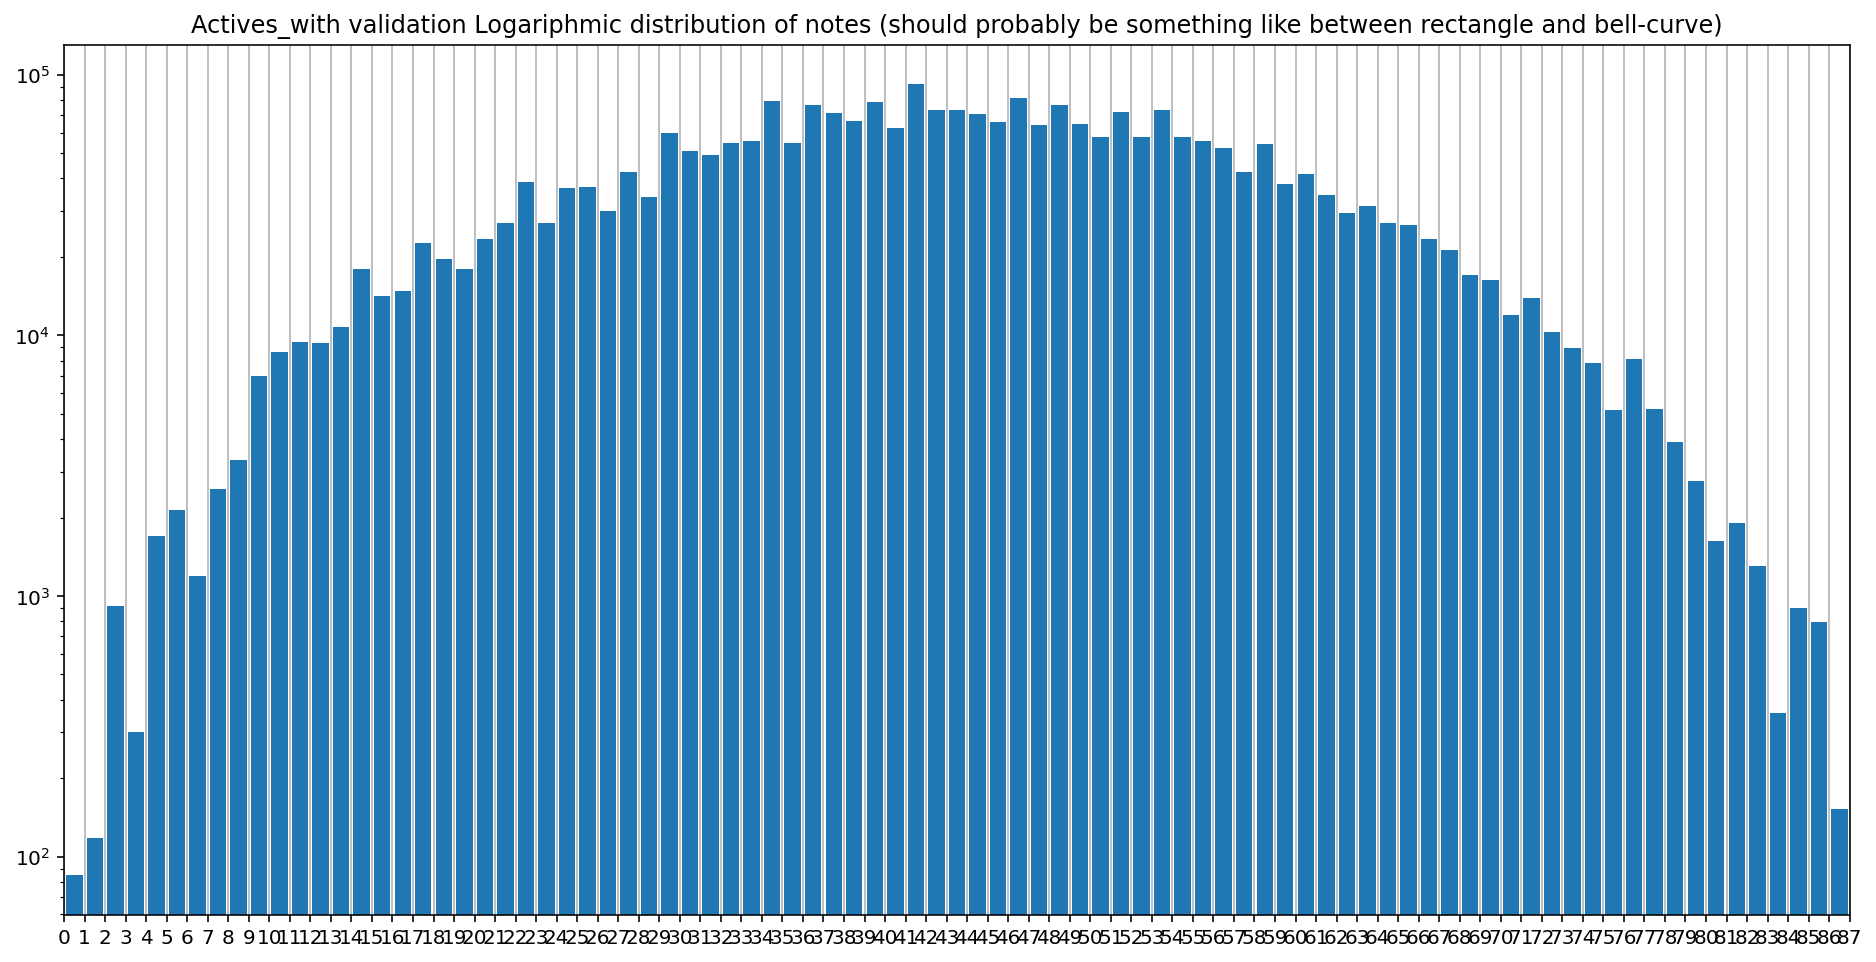

In [ ]:
PlotNotes('Actives_with')

# Only for String

In [ ]:
# train/val 폴더 npy 파일 통합 

with File(dataFolder + '/Mels_s train.hdf5', 'w') as f: #, rdcc_nbytes=1024**3*4) as f: # 4 GB cache size
    for splitFolder in ['train', 'validation']:
        print(splitFolder)
        mels, onsets, offsets, actives, volumes = [], [], [], [], []
        for i, [newMels, newOnsets, newOffsets, newActives, newVolumes] in enumerate(zip(*(glob('{}/{}/*{}.npy'.format(
                dataFolder, splitFolder, arr)) for arr in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
            # 추가
            if newOnsets.split(' ')[1][-4:] == '2021' :
              song = newOnsets.split(' ')[1]
              assert song == newOffsets.split(' ')[1] == newActives.split(' ')[1] == newVolumes.split(' ')[1], \
                  'Inconsistent number of numpy arrays'
              print('{} of {}'.format(i + 1, len(glob('{}/{}/*Actives.npy'.format(
                  dataFolder, splitFolder)))), end='\t')

              newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                  lambda arr: np.load(arr, allow_pickle=True), [newMels, newOnsets, newOffsets, newActives, newVolumes])
              
              if splitFolder == 'train':
                  # Memory Error, so at first collect data in resisable HDF5-file, then it can be re-saved to NumPy-file
                  if not mels: mels = f.create_dataset('Mels', data=newMels,
                      maxshape=(None, newMels.shape[1], newMels.shape[2])) # chunks=True
                  else:
                      mels.resize((len(mels) + len(newMels), mels.shape[1], mels.shape[2]))
                      mels[-len(newMels):] = newMels
              else: mels = (mels + newMels.tolist()) if splitFolder == 'test' \
                  else np.vstack([mels, newMels]) if len(mels) else newMels

              onsets, offsets, actives, volumes = map(lambda arr, newArr: (arr + newArr.tolist())
                  if splitFolder == 'test' else np.vstack([arr, newArr]) if len(arr) else newArr,
                  [onsets, offsets, actives, volumes], [newOnsets, newOffsets, newActives, newVolumes])

              print(song)

        for name, arr in zip(['Mels_s', 'Onsets_s', 'Offsets_s', 'Actives_s', 'Volumes_s'], [mels, onsets, offsets, actives, volumes]):
            np.save('{}/{} {}'.format(dataFolder, name, splitFolder), arr)
        print('\n', len(actives), 'samples')
        
        melsFlat, volsFlat = map(np.concatenate, [mels, volumes])
        melsMin, melsMean, melsMax = np.min(melsFlat), np.mean(melsFlat), np.max(melsFlat)
        print('Mels decibels           in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsMin, melsMean, melsMax))
        # assert melsMinMin < melsMin < melsMinMax and melsMeanMin < melsMean < melsMeanMax \
        #     and melsMaxMin < melsMax < melsMaxMax, 'Wrong mels decibels range'

        print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]\n'.format(
            volsFlat.min(), volsFlat.mean(), volsFlat.max()))
        for arr in map(np.concatenate, [onsets, offsets, actives]): assert ((arr == 0) | (arr == 1)).all(), \
                'Onsets, offsets and actives must be only zeros and ones'
        assert volsFlat.min() == 0 and 0 < volsFlat.max() <= 1, 'Wrong normalized MIDI volumes range'

'All splits combined'

train
2 of 4	Drive/maestro-v1.0.0//train/2021

 2087 samples
Mels decibels           in range [-77 ... -23 ... 43]
Midi normalized volumes in range [0.0 ... 0.0029 ... 0.47]

validation
2 of 4	Drive/maestro-v1.0.0//validation/2021

 256 samples
Mels decibels           in range [-66 ... -23 ... 42]
Midi normalized volumes in range [0.0 ... 0.0032 ... 0.47]



'All splits combined'